# Image Cleaning with Tailcuts

This notebook performs cleaning on CTA MST flashcam camera images and looks at the peformance.

In [1]:
# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# cta-pipe
import ctapipe
from ctapipe.image import dilate, tailcuts_clean, toymodel
from ctapipe.instrument import SubarrayDescription
from ctapipe.visualization import CameraDisplay

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [4]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


**Data preperation**

In [5]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


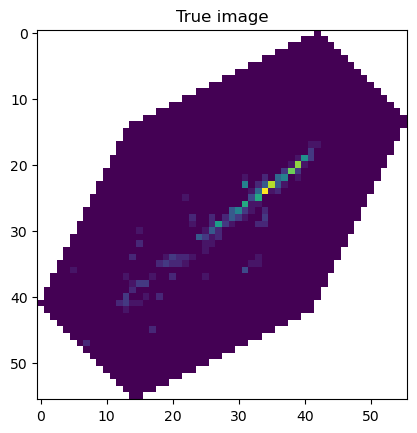

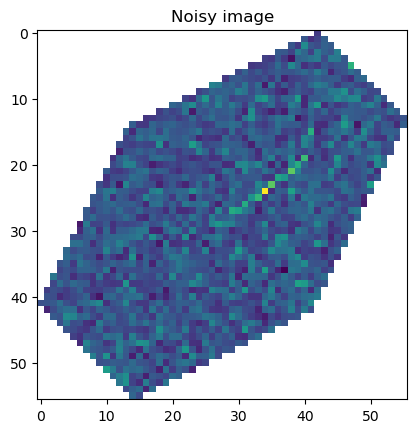

In [6]:
# Example showing the true image (only Cherenkov light) and the noisy image (Cherenkov light + noise)

fig1=plt.figure()
plt.title("True image")
plt.imshow(data_true_test_im[5])
plt.show()


fig2=plt.figure()
plt.title("Noisy image")
plt.imshow(data_noisy_test_im[5])
plt.show()

**Tailcuts function**

In [7]:
# Function to apply the tailcuts function

def get_cleaned_chunk_image(chunk_image):
    
    img_1d = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam').image_from_cartesian_representation(chunk_image)
    
    clean = tailcuts_clean(
            ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam'),
            img_1d,
            boundary_thresh=3.5,
            picture_thresh=7,
            min_number_picture_neighbors=2,
        )
    
    for i in range(2): # Dilate with 2 rows
        clean = dilate(ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam'), clean)

    img_1d[~clean] = 0.0
    img_clean_square = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam').image_to_cartesian_representation(img_1d)
    
    return img_clean_square

**Calculate performances**

In [8]:
# Using the Jaccard score to calculate the average IOU

IOU_list = []
IOU_tc = 0
for noisy, true in zip(data_noisy_test, data_true_test):
    clean_tc = get_cleaned_chunk_image(noisy.detach().numpy())
    clean_tc = clean_tc.reshape(56*56)
    clean_tc_binary = np.ones(np.shape(clean_tc))
    clean_tc_binary[np.nan_to_num(clean_tc)==0] = 0
    
    clean_tc = torch.nan_to_num((torch.from_numpy(clean_tc_binary)))
    
    iou = jaccard_score(clean_tc, true)
    IOU_list.append(iou)
    IOU_tc += iou
    
    
IOU = IOU_tc/len(data_noisy_test)
IOU_arr = np.array(IOU_list)
    
print(f'IOU of tailcuts: {IOU}')

IOU of tailcuts: 0.4070115627594698


In [9]:
# Save the distribution of IoUs

np.save("data_output/IOU_tc_dis.npy", IOU_arr)

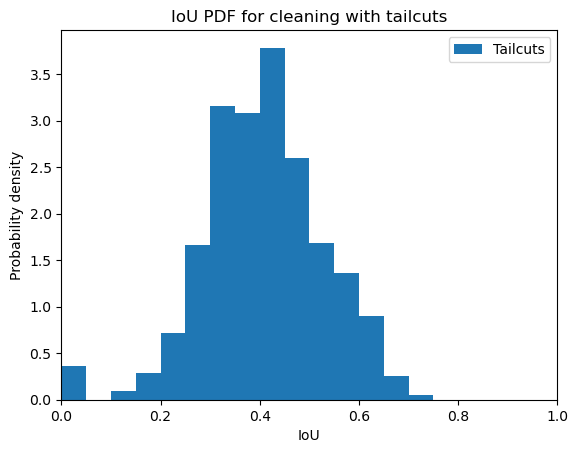

In [10]:
fig_iou = plt.figure()
plt.title("IoU PDF for cleaning with tailcuts")
plt.xlabel("IoU")
plt.ylabel("Probability density")
plt.hist(IOU_arr, density=True, bins=20, range=(0,1), label='Tailcuts')
plt.xlim(0,1)
plt.legend()
plt.show()
fig_iou.savefig("images/IOU_tc_distribution.pdf")

In [11]:
# Calculate this for normalization

pix_max = np.nanmax(data_noisy_arr, axis=(1,2))
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))

pix_max_test = pix_max[idx_split:]
pix_min_test = pix_min[idx_split:]

In [12]:
# Normalized MSE

MSE_tc = 0
MSE_list = []
data_true_test_con = data_true[images_high_mask][idx_split:]
for noisy, true, pixmax in zip(data_noisy_test, data_true_test_con, pix_max_test):
    noisy_array = noisy.detach().numpy()
    clean_tc = get_cleaned_chunk_image(noisy_array)
    clean_tc = clean_tc/pixmax
    
    clean_tc = torch.nan_to_num((torch.from_numpy(clean_tc)))
    true = true/pixmax
    true[nan_mask] = 0
    
    mse = F.mse_loss(clean_tc, torch.tensor(true))
    MSE_list.append(mse)
    MSE_tc += mse
    
    
MSE_tc = MSE_tc/len(data_noisy_test)
    
print(f'Normalized MSE of tailcuts: {MSE_tc}')

MSE_arr = np.array(MSE_list)

Normalized MSE of tailcuts: 0.0002986057091538999


In [13]:
# Save the distribution of MSEs

np.save("data_output/MSE_tc_dis.npy", MSE_arr)

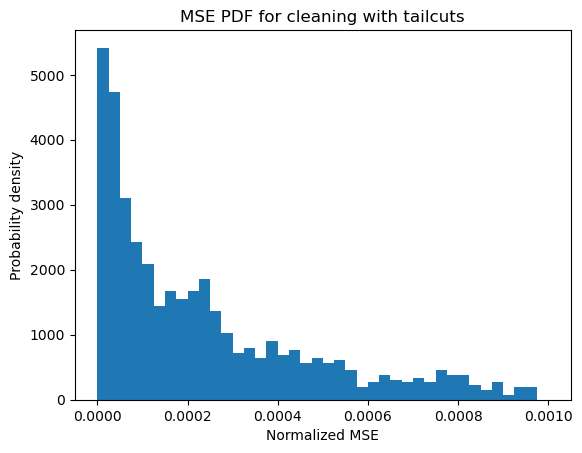

In [14]:
fig_mse=plt.figure()
plt.hist(MSE_arr, bins=40, range=(0,0.001), density='True', label='Tailcuts')
plt.xlabel("Normalized MSE")
plt.ylabel("Probability density")
plt.title("MSE PDF for cleaning with tailcuts")
plt.show()
fig_mse.savefig("images/MSE_tc_distribution.pdf")

**Show some examples**

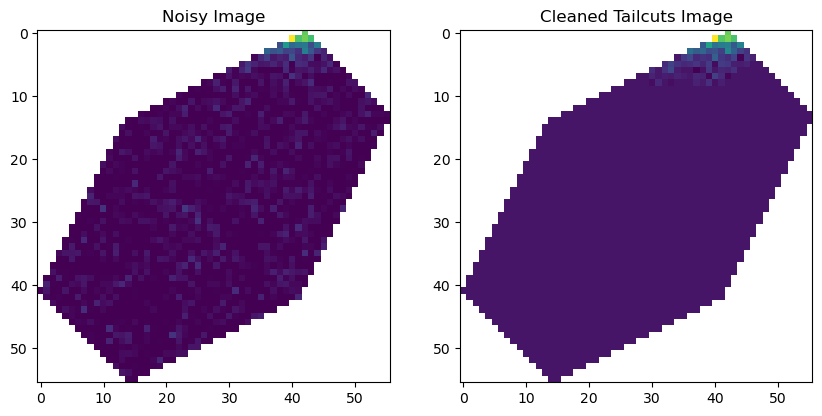

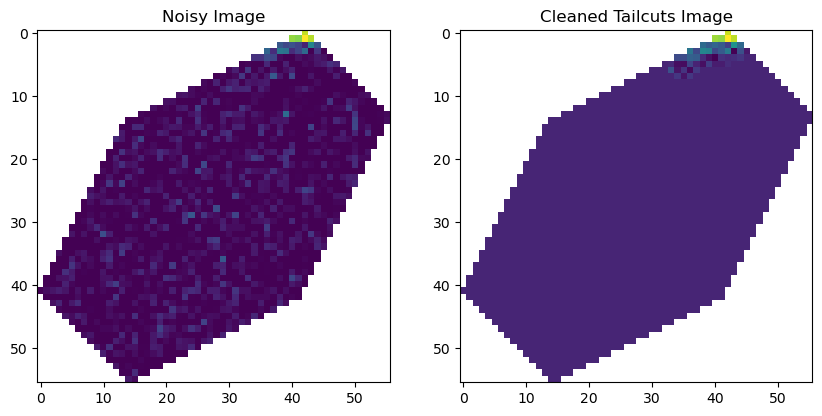

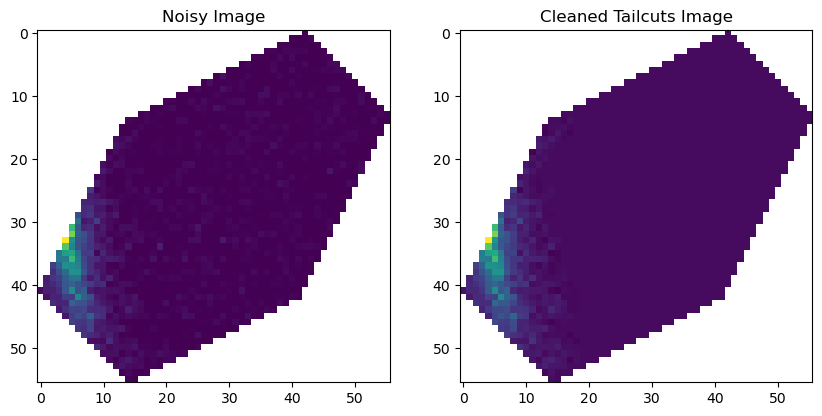

In [22]:
n_start = 10
n_im = 3

for im_i in range(n_start, n_start+n_im):
    
    clean_tc = get_cleaned_chunk_image((data_noisy[im_i]))
    
    fig, axs = plt.subplots(1,2,figsize=(10, 5))

    axs[0].imshow(data_noisy[im_i], vmin=0)
    axs[0].set_title("Noisy Image")
    
    axs[1].imshow(clean_tc)
    axs[1].set_title("Cleaned Tailcuts Image")
    

plt.show()    
    